In [173]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.path.dirname('Utils'), '..')))
from Utils.data_utils import load_preprocessed_data_from_folder

# Load the data from the CSV file into a pandas DataFrame
data = load_preprocessed_data_from_folder()

data

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,0.502784,0.571139,0.336096,0.543891,0.680385,0.669439,0.313402,0.699753,0.286091,0.0
1,0.265434,0.297400,0.300611,0.491839,0.602571,0.719411,0.497319,0.450999,0.576793,0.0
2,0.578509,0.641311,0.321619,0.698543,0.563298,0.414652,0.562017,0.532866,0.303637,0.0
3,0.594055,0.605536,0.356244,0.603314,0.647347,0.317880,0.622089,0.808065,0.601015,0.0
4,0.649445,0.484851,0.289922,0.484900,0.514545,0.379337,0.358555,0.253606,0.496327,0.0
...,...,...,...,...,...,...,...,...,...,...
3991,0.560356,0.434710,0.215044,0.535173,0.515598,0.341800,0.578386,0.497830,0.644700,1.0
3992,0.369342,0.453484,0.419993,0.555453,0.659636,0.310077,0.418230,0.518917,0.459890,1.0
3993,0.514873,0.394047,0.550464,0.706030,0.415335,0.544953,0.446907,0.582838,0.610959,1.0
3994,0.500670,0.484272,0.490260,0.783886,0.364165,0.535721,0.349975,0.552053,0.439660,1.0


In [174]:
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.2
NUM_FOLDS = 5

train_df, test_df = train_test_split(data, test_size=TEST_SIZE)
train_df, test_df

(            ph  Hardness    Solids  Chloramines   Sulfate  Conductivity  \
 3061  0.284931  0.611712  0.654354     0.558546  0.513594      0.380450   
 1369  0.580090  0.554683  0.411974     0.484982  0.525780      0.403077   
 2705  0.377905  0.409878  0.146851     0.698244  0.652066      0.495034   
 1497  0.620939  0.622964  0.266622     0.667320  0.642856      0.636075   
 3985  0.497542  0.599841  0.312812     0.223226  0.524555      0.464740   
 ...        ...       ...       ...          ...       ...           ...   
 3213  0.527460  0.761007  0.456901     0.441687  0.588194      0.647653   
 1912  0.554299  0.575921  0.557073     0.593220  0.483286      0.289752   
 2264  0.456882  0.286765  0.325004     0.580175  0.847590      0.443806   
 909   0.501203  0.435015  0.290513     0.434525  0.663361      0.507119   
 2417  0.511361  0.413674  0.414915     0.770061  0.677772      0.260670   
 
       Organic_carbon  Trihalomethanes  Turbidity  Potability  
 3061        0.344319 

In [175]:
# bisect the data into features and target (potability)
train_x = train_df.drop('Potability', axis=1)
train_y = train_df['Potability']

test_x = test_df.drop('Potability', axis=1)
test_y = test_df['Potability']

In [176]:
# Naive random forest model

from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()
random_forest.fit(train_x, train_y)

print(f'Random Forest test accuracy: {random_forest.score(test_x, test_y):0.2%}')

Random Forest test accuracy: 76.50%


In [177]:
from sklearn.model_selection import GridSearchCV

params = {
  'n_estimators': [100, 200],
  # 'max_depth': [None, 10, 20, 50],
  'min_samples_split': [2, 5, 10],
  'min_samples_leaf': [1, 2, 4],
  'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(random_forest, params, scoring='f1', verbose=4, cv=NUM_FOLDS, n_jobs=-1)
grid_search.fit(train_x, train_y)

print(f'Random Forest test accuracy: {grid_search.score(test_x, test_y):0.2%}')

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Random Forest test accuracy: 75.64%


In [178]:
best_model = grid_search.best_estimator_
print(f'Best model: {best_model}, best params: {grid_search.best_params_}')

print(f'Best model score: {best_model.score(test_x, test_y):0.2%}')

Best model: RandomForestClassifier(min_samples_split=5, n_estimators=200), best params: {'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best model score: 76.25%


In [179]:
from sklearn.calibration import CalibratedClassifierCV

ideal_rf = RandomForestClassifier(**grid_search.best_params_)

calibrated_rf = CalibratedClassifierCV(ideal_rf, cv=NUM_FOLDS)
calibrated_rf.fit(train_x, train_y)

print(f'Calibrated Random Forest test accuracy: {calibrated_rf.score(test_x, test_y):0.2%}')

Calibrated Random Forest test accuracy: 76.12%


In [180]:
calibrated_rf.predict_proba(test_x)

array([[0.70661595, 0.29338405],
       [0.38875292, 0.61124708],
       [0.80175828, 0.19824172],
       ...,
       [0.80243294, 0.19756706],
       [0.11828965, 0.88171035],
       [0.56096981, 0.43903019]])

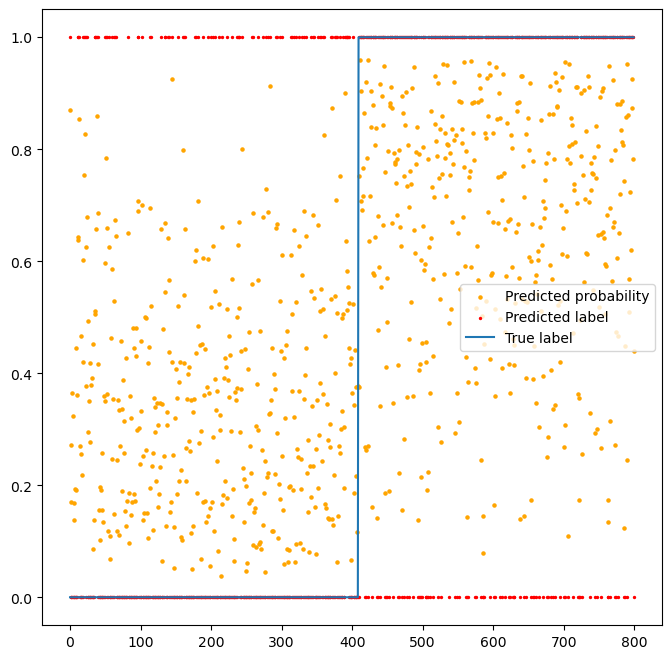

In [181]:
import matplotlib.pyplot as plt
import numpy as np

# Create a zipped array of sample index, predicted proability and true label
results = np.column_stack((calibrated_rf.predict_proba(test_x)[:, 1], calibrated_rf.predict(test_x), test_y))

# Sort by true label
results = results[results[:, 2].argsort()]

# Plot the predicted probabilities & true labels

plt.figure(figsize=(8, 8))
plt.scatter(range(len(results)), results[:, 0], label='Predicted probability', c='orange', s=5)
plt.scatter(range(len(results)), results[:, 1], label='Predicted label', c='red', s=2)
plt.plot(results[:, 2], label='True label')
plt.legend()

plt.show()


